# Lesson 1: Router Engine

Welcome to Lesson 1.

To access the `requirements.txt` file, the data/pdf file required for this lesson and the `helper` and `utils` modules, please go to the `File` menu and select`Open...`.

I hope you enjoy this course!

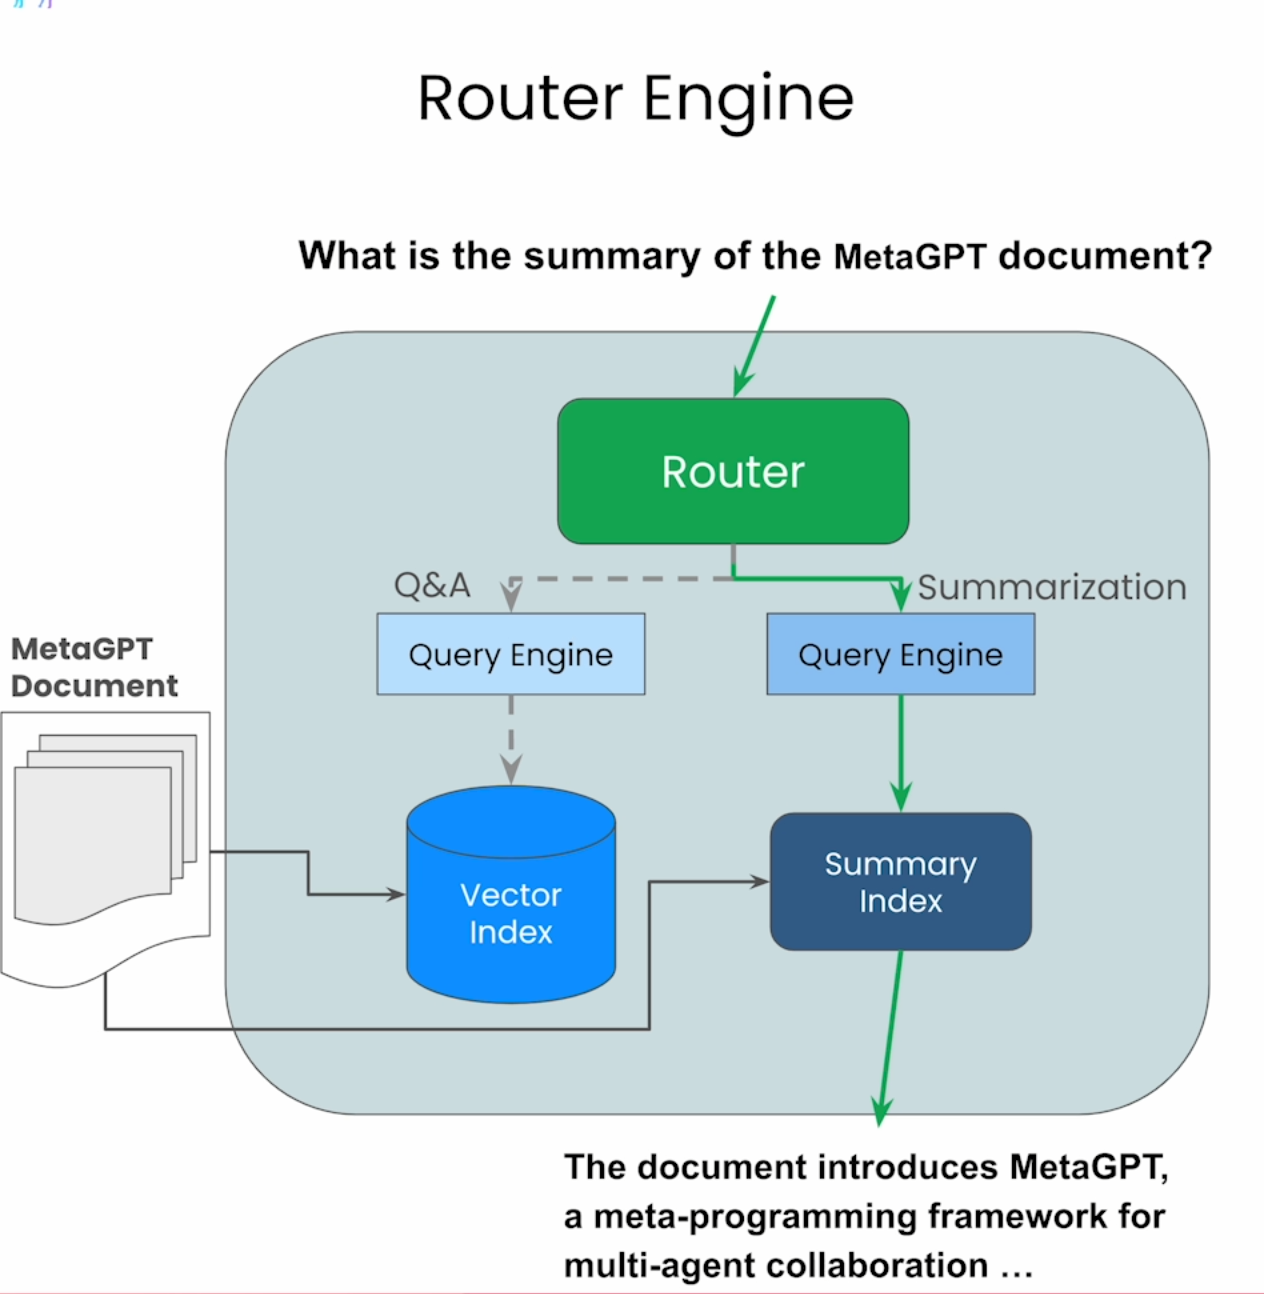

## Setup

In [1]:
from helper import get_openai_api_key

OPENAI_API_KEY = get_openai_api_key()

In [2]:
#needed to get jupyter work well with llama index
import nest_asyncio

nest_asyncio.apply()

## Load Data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [3]:
from llama_index.core import SimpleDirectoryReader

# load documents
documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()

## Define LLM and Embedding model

In [5]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [6]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")

## Define Summary Index and Vector Index over the Same Data

In [7]:
from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes)

## Define Query Engines and Set Metadata

In [8]:
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
vector_query_engine = vector_index.as_query_engine()

In [9]:
from llama_index.core.tools import QueryEngineTool


summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=(
        "Useful for summarization questions related to MetaGPT"
    ),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific context from the MetaGPT paper."
    ),
)

## Define Router Query Engine

In [10]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector


query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True
)

In [11]:

response = query_engine.query("What is the summary of the document?")
print(str(response))

Selecting query engine 0: Useful for summarization questions related to MetaGPT.
The document introduces MetaGPT, a meta-programming framework that enhances multi-agent systems using Large Language Models (LLMs) by incorporating human-like Standardized Operating Procedures (SOPs). MetaGPT assigns specific roles to agents, streamlines workflows, and utilizes structured communication interfaces to improve collaboration efficiency. It implements executable feedback mechanisms to achieve state-of-the-art performance in code generation benchmarks. The document discusses the importance of role specialization, structured communication, and efficient information sharing mechanisms in artificial multi-agent systems. It also outlines the software development process using MetaGPT for projects like creating a "Drawing App," detailing the roles of different agents and their contributions. Additionally, the document addresses the performance of GPT models in HumanEval benchmark experiments, highlig

In [12]:
print(len(response.source_nodes)) #this shows that summary engine is being called as summary engine retrieves all the nodes

34


In [13]:
response = query_engine.query(
    "How do agents share information with other agents?"
)
print(str(response))

Selecting query engine 1: This choice is more relevant as it specifically mentions retrieving specific context from the MetaGPT paper, which would likely include information on how agents share information with other agents..
Agents share information with other agents by utilizing a shared message pool where they can publish structured messages. This shared message pool allows all agents to exchange messages directly, enabling them to both publish their own messages and access messages from other agents transparently. Additionally, agents can subscribe to relevant messages based on their role profiles, allowing them to extract the information they need for their specific tasks and responsibilities.


## Let's put everything together

In [14]:
from utils import get_router_query_engine

query_engine = get_router_query_engine("metagpt.pdf")

In [15]:
response = query_engine.query("Tell me about the ablation study results?")
print(str(response))

Selecting query engine 1: The ablation study results are specific context from the MetaGPT paper, making choice 2 the most relevant..
The ablation study results show that MetaGPT effectively addresses challenges related to information overload and reduces hallucinations in software generation. By utilizing a global message pool and a subscription mechanism, MetaGPT efficiently manages excessive or irrelevant information, ensuring relevance and utility. Additionally, focusing on granular tasks like requirement analysis and package selection guides the thinking process, which helps in overcoming issues faced by large language models in software generation.
